<a href="https://colab.research.google.com/github//pylabel-project/samples/blob/main/dataset_splitting.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

# Splitting Images Datasets with PyLabel
This notebook demonstrates how to use the splitting capabilities of PyLabel split an image dataset (with images and annotations) into train, val, and test groups.

Splitting image datasets is trickier than splitting a simple table of data because you need to ensure that all of the labels for a particular image stay in the same split as the image (with no leakage) and you have to split the images as well as the annotations. 

PyLabel has 2 methods for splitting data: 
1)	**GroupShuffleSplit**, which uses the GroupShuffleSplit command from sklearn.
2)	**StratifiedGroupShuffleSplit**, which attempts to balance the distribution of classes evenly across the split groups. 

In [1]:
import logging
logging.getLogger().setLevel(logging.CRITICAL)
#!pip install pylabel > /dev/null
from pylabel import importer

## Import A Dataset 
First we will import dateset stored in COCO format. (This is a sample  data set. You can edit this part to point to your dataset.)


In [2]:
import os, zipfile

#Download sample  dataset 
os.makedirs("data", exist_ok=True)
!wget "https://github.com/pylabelalpha/notebook/blob/main/BCCD_coco.zip?raw=true" -O data/BCCD_coco.zip
with zipfile.ZipFile("data/BCCD_coco.zip", 'r') as zip_ref:
   zip_ref.extractall("data")

#Specify path to the coco.json file
path_to_annotations = "data/BCCD_Dataset.json"
#Specify the path to the images (if they are in a different folder than the annotations)
path_to_images = ""

#Import the dataset into the pylable schema 
dataset = importer.ImportCoco(path_to_annotations, path_to_images=path_to_images, name="BCCD_coco")
dataset.df.head(5)

--2021-12-01 07:46:40--  https://github.com/pylabelalpha/notebook/blob/main/BCCD_coco.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pylabelalpha/notebook/raw/main/BCCD_coco.zip [following]
--2021-12-01 07:46:41--  https://github.com/pylabelalpha/notebook/raw/main/BCCD_coco.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pylabelalpha/notebook/main/BCCD_coco.zip [following]
--2021-12-01 07:46:41--  https://raw.githubusercontent.com/pylabelalpha/notebook/main/BCCD_coco.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respo

,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_segmentation,ann_iscrowd,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split,annotated
id,,,,,,,,,,,,,,,,,,,,,
0,,BloodImage_00315.jpg,None,0,640,480,3,0,164.0,261.0,...,None,None,Unspecified,0,0,0,RBC,None,,1
1,,BloodImage_00315.jpg,None,0,640,480,3,0,15.0,66.0,...,None,None,Unspecified,0,0,0,RBC,None,,1
2,,BloodImage_00315.jpg,None,0,640,480,3,0,13.0,234.0,...,None,None,Unspecified,0,0,0,RBC,None,,1
3,,BloodImage_00315.jpg,None,0,640,480,3,0,239.0,3.0,...,None,None,Unspecified,0,0,0,RBC,None,,1
4,,BloodImage_00315.jpg,None,0,640,480,3,0,542.0,109.0,...,None,None,Unspecified,1,0,0,RBC,None,,1


## Analyze annotations
Pylabel can calculate basic summary statisticts about the dataset such as the number of files and the classes. 
The dataset is stored as a pandas frame so the developer can do additional exploratory analysis on the dataset. 

In [3]:
print(f"Number of images: {dataset.analyze.num_images}")
print(f"Number of classes: {dataset.analyze.num_classes}")
print(f"Classes:{dataset.analyze.classes}")
print(f"Class counts:\n{dataset.analyze.class_counts}")

Number of images: 364
Number of classes: 3
Classes:['RBC', 'WBC', 'Platelets']
Class counts:
RBC          4155
WBC           372
Platelets     361
Name: cat_name, dtype: int64


## Visualize Annotations 
You can render the bounding boxes for your image to inspect them and confirm that they imported correctly.  

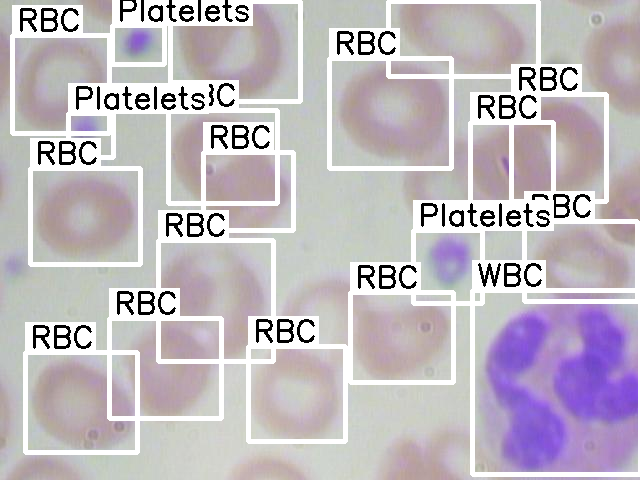

In [4]:
from IPython.display import Image, display
display(dataset.visualize.ShowBoundingBoxes(100))

## Split Dataset Using GroupShuffleSplit
After running the split commmand the value of the split column will be set to test, train, or val depending on what group the row was split into. 

In [5]:
dataset.splitter.GroupShuffleSplit(train_pct=.6, val_pct=.2, test_pct=.2)
dataset.analyze.ShowClassSplits()

,all,train,test,val
cat_name,,,,
RBC,0.850041,0.853001,0.838446,0.852761
WBC,0.076105,0.071282,0.080777,0.085890
Platelets,0.073854,0.075716,0.080777,0.061350


## Split Dataset Using StratifiedGroupShuffleSplit
Note that the distribution of classes should be more balanced. Increasing the batch_size will improve performance, but may make the distribution less balanced. 

In [6]:
dataset.splitter.StratifiedGroupShuffleSplit(train_pct=.6, val_pct=.2, test_pct=.2, batch_size=1)
dataset.analyze.ShowClassSplits()

,all,train,test,val
cat_name,,,,
RBC,0.850041,0.850303,0.849287,0.85000
WBC,0.076105,0.075523,0.076375,0.07766
Platelets,0.073854,0.074174,0.074338,0.07234


# Export Split Dataset
PyLabel can export the dataset into train, test, val groups and even even create a YAML file for YOLOv5 datasets, 

In [7]:
dataset.export.ExportToYoloV5(output_path='model_training/labels',yaml_file='dataset.yaml', copy_images=True, use_splits=True)

['model_training/dataset.yaml',
 'model_training/labels/train/BloodImage_00198.txt',
 'model_training/labels/train/BloodImage_00245.txt',
 'model_training/labels/train/BloodImage_00389.txt',
 'model_training/labels/train/BloodImage_00016.txt',
 'model_training/labels/train/BloodImage_00169.txt',
 'model_training/labels/train/BloodImage_00101.txt',
 'model_training/labels/train/BloodImage_00288.txt',
 'model_training/labels/train/BloodImage_00023.txt',
 'model_training/labels/train/BloodImage_00405.txt',
 'model_training/labels/train/BloodImage_00294.txt',
 'model_training/labels/train/BloodImage_00047.txt',
 'model_training/labels/train/BloodImage_00403.txt',
 'model_training/labels/train/BloodImage_00325.txt',
 'model_training/labels/train/BloodImage_00388.txt',
 'model_training/labels/train/BloodImage_00029.txt',
 'model_training/labels/train/BloodImage_00000.txt',
 'model_training/labels/train/BloodImage_00259.txt',
 'model_training/labels/train/BloodImage_00180.txt',
 'model_traini

In [8]:
!cat 'model_training/dataset.yaml'

names:
- RBC
- Platelets
- WBC
nc: 3
path: ..
test: model_training/images/test
train: model_training/images/train
val: model_training/images/val
